# ⁠Autonomous Object Detection System
Problem Statement
Object detection is crucial for autonomous systems such as self-driving cars and surveillance.
This project builds a real-time object detection system using deep learning.


Imports

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import cv2
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import random

GPU Check

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Shit we will be using
- Framework: Tensorflow
- Model: SSD MobileNet
- Dataset: COCO128

Resources used
- Youtube: codebasics, DeepBeaning
- v7labs.com
- and ofcourse heavy use of ChatGPT

Kaggle Creds

In [7]:
from google.colab import userdata
import os

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_API_TOKEN")


Defining the classes by COCO

In [8]:
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Parameters


In [9]:
GRID_SIZE = 13
BOXES_PER_CELL = 3
NUM_CLASSES = 80
INPUT_SIZE = 416
CELL_SIZE = 32

Loading the dataset

In [10]:
path = kagglehub.dataset_download("ultralytics/coco128")

print(path)
print(os.listdir(path))

100%|██████████| 6.66M/6.66M [00:01<00:00, 4.98MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/ultralytics/coco128/versions/3
['coco128']


In [11]:
IMG_DIR = os.path.join(path, "coco128","images", "train2017")
LABEL_DIR = os.path.join(path, "coco128","labels","train2017")

In [12]:
print("images: ",len(os.listdir(IMG_DIR)))
print("labels: ",len(os.listdir(LABEL_DIR)))

images:  128
labels:  128


Loading the image and label in sorted pairs

In [13]:
image_files = sorted(os.listdir(IMG_DIR))
label_files = sorted(os.listdir(LABEL_DIR))

Loading an image and drawing bounding boxes around it

In [14]:
def load_image_label(index):
  # picking nth image
  image_name = image_files[index]
  label_name = label_files[index]

  # loading the image
  img_path = os.path.join(IMG_DIR, image_name)
  img = cv2.imread(img_path)

  if img is None:
    print(f"no image at {img_path}")
    return None, None, None, None, None,

  height, width, channels = img.shape

  # reading the label file
  with open(os.path.join(LABEL_DIR, label_name), 'r') as f:
    labels = f.readlines()

  return image_name, img, labels, height, width


In [15]:
def label_to_bb(label, width, height):
  parts_string = label.split()
  parts = [float(x) for x in parts_string]

  # convert label data to data for bb in pixels
  class_id = int(parts[0])
  x_center = float(parts[1]) * width
  y_center = float(parts[2])*height
  box_width = float(parts[3])*width
  box_height = float(parts[4])*height

  # convert center coord to corner coord to draw bb
  # top left
  x1 = x_center-(box_width/2)
  y1 = y_center-(box_height/2)
  # bottom right
  x2 = x_center+(box_width/2)
  y2 = y_center+(box_height/2)

  return class_id, int(x1), int(y1), int(x2), int(y2)

In [16]:
def draw_bb(index):
  image_name, img, labels, height, width = load_image_label(index)

  img_bb = img.copy()

  for label in labels:
    class_id, x1, y1, x2, y2 = label_to_bb(label, width, height)
    class_name = COCO_CLASSES[class_id]

    # random color for the bb
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    img_bb = cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    img_bb = cv2.putText(img_bb, class_name, (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  plt.figure(figsize=(12, 8))
  plt.imshow(cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(f"{image_name} - {len(labels)} objects")
  plt.show()

  return img_bb


Preprocessing Image and Label

In [17]:
def preprocess_image(img):
  resize_img = cv2.resize(img, (INPUT_SIZE,INPUT_SIZE), interpolation=cv2.INTER_LINEAR)
  normalized_img = resize_img / 255.0

  return normalized_img


In [18]:
def preprocess_labels(labels):
    processed = []
    for label in labels:
        parts = label.strip().split()
        # class_id, x_center, y_center, width, height
        parsed = [float(parts[0])] + [float(x) for x in parts[1:]]
        processed.append(parsed)

    return processed


Dataset Creation

In [19]:
def create_dataset():
  preprocessed_images = []
  preprocessed_labels = []

  print(f"processing {len(image_files)} images...")

  for i in range(len(image_files)):
    image_name, img, labels, height, width = load_image_label(i)

    preprocessed_img = preprocess_image(img)
    processed_labels = preprocess_labels(labels)

    preprocessed_images.append(preprocessed_img)
    preprocessed_labels.append(processed_labels)

  print(f"Total images: {len(preprocessed_images)}")
  print(f"Total labels: {len(preprocessed_labels)}")

  return preprocessed_images, preprocessed_labels

In [20]:
def train_val_split(images,labels,train_ratio=0.8):
  split_index = int(len(images)*train_ratio)

  train_images = images[:split_index]
  train_labels = labels[:split_index]
  val_images = images[split_index:]
  val_labels = labels[split_index:]

  return train_images, train_labels, val_images, val_labels

Grid based label

In [21]:
def prepare_grid_labels(labels):
  y=[]

  for label in labels:
    # empty grid
    grid = np.zeros((GRID_SIZE,GRID_SIZE,BOXES_PER_CELL,NUM_CLASSES+5))
    # no of bb per grid
    cell_bb_count = np.zeros((GRID_SIZE,GRID_SIZE), dtype=int)

    for obj in label:
      class_id = int(obj[0])
      x_center = float(obj[1])
      y_center = float(obj[2])
      width = float(obj[3])
      height = float(obj[4])

      # grid the object is in
      grid_x=int(x_center*GRID_SIZE)
      grid_y=int(y_center*GRID_SIZE)
      # if coord is 1 then the grid becomes 13 and bam out of bounds error
      grid_x=min(grid_x,GRID_SIZE-1)
      grid_y=min(grid_y,GRID_SIZE-1)

      # checking whether the grid has room for another bb
      cell_count_current = cell_bb_count[grid_y,grid_x]

      if cell_count_current>=BOXES_PER_CELL:
        # if max(=3) objects reached then skip object
        print(f"({grid_y,{grid_x}}) full, skipping obejct")
        continue

      # calculating where in the cell the object is instead of the whole ass image
      # absolute pos in form of grid
      x_abs=x_center*GRID_SIZE
      y_abs=y_center*GRID_SIZE
      # pos within the cell
      x_rel=x_abs-grid_x
      y_rel=y_abs-grid_y

      # using one hot encoding to not confuse this dumb aah model
      class_one_hot = np.zeros(NUM_CLASSES)
      class_one_hot[class_id] = 1.0

      bbox = np.array([x_rel,y_rel,width,height])
      # if confidence 1 then object there
      # putting confidence manually so the model can filter empty cells
      confidence = np.array([1.0])

      label = np.concatenate([class_one_hot,bbox,confidence])
      # assinging that label to the grid it corresponds to
      grid[grid_y, grid_x, cell_count_current]=label
      # mark that grid used
      cell_bb_count[grid_y,grid_x] += 1

    y.append(grid)

  return np.array(y)


Loss function

In [22]:
def grid_detection_loss(y_true, y_pred):
  # will combine three losses
  # is it the right object, is the box in the right place, is there an object

  # seperating the classes -> 0-79: class, 80-83: bb data, 84: confidence
  y_true_class = y_true[..., :NUM_CLASSES]
  y_pred_class = y_pred[..., :NUM_CLASSES]
  y_true_bb = y_true[..., NUM_CLASSES:NUM_CLASSES+4]
  y_pred_bb = y_pred[..., NUM_CLASSES:NUM_CLASSES+4]
  y_true_conf = y_true[..., -1:]
  y_pred_conf = y_pred[..., -1:]

  # having a mask matrix same as conf matrix which we can multiply later so that empty grid would not be calculated
  obj_mask = y_true_conf

  class_loss = keras.losses.categorical_crossentropy(y_true_class, y_pred_class)
  class_loss = class_loss * tf.squeeze(obj_mask, axis=-1)
  class_loss = tf.reduce_mean(class_loss)

  bb_loss = tf.reduce_mean(tf.square(y_true_bb-y_pred_bb),axis=-1,keepdims=True)
  bb_loss = bb_loss*obj_mask
  bb_loss = tf.reduce_mean(bb_loss)

  conf_loss = keras.losses.binary_crossentropy(y_true_conf, y_pred_conf)
  conf_loss = tf.reduce_mean(conf_loss)

  # adding weights
  total_loss = class_loss + 5.0*bb_loss + conf_loss

  return total_loss

Building the model

In [23]:
backbone = keras.applications.MobileNetV2(
    input_shape = (INPUT_SIZE,INPUT_SIZE,3),
    include_top=False,
    weights='imagenet',
    alpha=1.0
)

backbone.trainable = False

/tmp/ipython-input-3848886532.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [24]:
inputs = keras.Input(shape=(INPUT_SIZE,INPUT_SIZE,3))

layers = keras.layers

x = backbone(inputs, training=False)

x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

num_outputs = BOXES_PER_CELL * (NUM_CLASSES + 5)

outputs = layers.Conv2D(num_outputs, (1, 1), activation='sigmoid')(x)
outputs = layers.Reshape((GRID_SIZE, GRID_SIZE, BOXES_PER_CELL, NUM_CLASSES + 5))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 13, 13, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 13, 512)    │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 255)    │        32,895 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13, 13, 3, 85)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,667,647 (36.88 MB)

 Trainable params: 7,408,127 (28.26 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

Data Preparation

In [26]:
all_images, all_labels = create_dataset()
print(f"Dataset created: {len(all_images)} images")

processing 128 images...
Total images: 128
Total labels: 128
Dataset created: 128 images


Train val split

In [27]:
train_imgs, train_labels, val_imgs, val_labels = train_val_split(all_images, all_labels, train_ratio=0.8)

Convert to grid format

In [28]:
x_train = np.array(train_imgs)
x_val = np.array(val_imgs)
y_train=prepare_grid_labels(train_labels)
y_val=prepare_grid_labels(val_labels)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

((6, {7})) full, skipping obejct
((6, {9})) full, skipping obejct
((9, {6})) full, skipping obejct
((5, {2})) full, skipping obejct
((5, {10})) full, skipping obejct
((5, {10})) full, skipping obejct
((9, {4})) full, skipping obejct
((9, {4})) full, skipping obejct
((10, {9})) full, skipping obejct
((10, {9})) full, skipping obejct
((11, {8})) full, skipping obejct
x_train: (102, 416, 416, 3)
y_train: (102, 13, 13, 3, 85)
x_val shape: (26, 416, 416, 3)
y_val shape: (26, 13, 13, 3, 85)


Compile model

In [29]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=grid_detection_loss,
    metrics=['mae']
)

Train model

In [30]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [31]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - loss: 0.4011 - mae: 0.4759 - val_loss: 0.7568 - val_mae: 0.2982 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1475 - mae: 0.3492 - val_loss: 0.4671 - val_mae: 0.2189 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1158 - mae: 0.2474 - val_loss: 0.2535 - val_mae: 0.1615 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0929 - mae: 0.1841 - val_loss: 0.1911 - val_mae: 0.1227 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0797 - mae: 0.1400 - val_loss: 0.1572 - val_mae: 0.1040 - learning_rate: 0.0010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0652 - mae: 0.1104 - val_loss: 0.1448 - val_mae: 0.0884 - learning_rate: 0.0010
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0560 - mae: 0.0910 - val_loss: 0.1513 - val_mae: 0.0796 - learning_rate: 0.0010
Epoch 8/20
13/

Save model

In [32]:
model.save('yolo_type_shi.h5')

Plots and shit

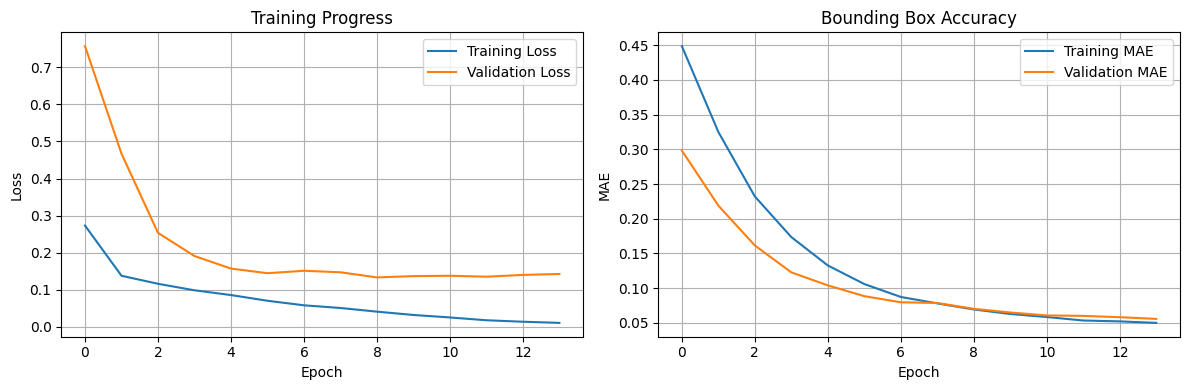

In [33]:
plt.figure(figsize=(12, 4))

# loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Bounding Box Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Testing shit

In [38]:
def decode_predictions(predictions, conf_threshold=0.5):
  boxes=[]
  classes=[]
  confidences=[]

  for grid_y in range(GRID_SIZE):
        for grid_x in range(GRID_SIZE):
            for box_idx in range(BOXES_PER_CELL):
                pred = predictions[grid_y, grid_x, box_idx]

                confidence = pred[-1]

                if confidence < conf_threshold:
                    continue

                # getting the class with the highest probability
                class_probs = pred[:NUM_CLASSES]
                class_id = np.argmax(class_probs)
                class_confidence = class_probs[class_id] * confidence

                if class_confidence < conf_threshold:
                    continue

                # bb coords
                x_rel = pred[NUM_CLASSES]
                y_rel = pred[NUM_CLASSES + 1]
                width = pred[NUM_CLASSES + 2]
                height = pred[NUM_CLASSES + 3]

                # pos in whole img
                x_center = (grid_x + x_rel) / GRID_SIZE
                y_center = (grid_y + y_rel) / GRID_SIZE

                boxes.append([class_id, x_center, y_center, width, height])
                confidences.append(class_confidence)

  return boxes, confidences

In [42]:
def test_image(model, index, conf_threshold=0.3):
  img_name, img, labels, height, width = load_image_label(index)

  preproccessed_img=preprocess_image(img)
  # model expects batch dimension so adding that
  input_batch = np.expand_dims(preproccessed_img, axis=0)

  predictions = model.predict(input_batch, verbose=0)[0]

  boxes, confidences = decode_predictions(predictions, conf_threshold=conf_threshold)

  img_pred=img.copy()
  # each detected box's label is formatted into string
  for box, conf in zip(boxes, confidences):
    label_string = f"{int(box[0])} {box[1]} {box[2]} {box[3]} {box[4]}"
    class_id, x1, y1, x2, y2 = label_to_bb(label_string, width, height)

    class_name = COCO_CLASSES[class_id]
    color = (0, 255, 0)  # green->prediction

    # drawing bb
    cv2.rectangle(img_pred, (x1, y1), (x2, y2), color, 2)
    # put a label on that thang
    label_text = f"{class_name}: {conf:.2f}"
    cv2.putText(img_pred, label_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # display that thang
  plt.figure(figsize=(12, 8))
  plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(f"{img_name} - {len(boxes)} objects detected")
  plt.show()

  print(f"\nImage: {img_name}")
  print(f"Detected {len(boxes)} objects:")
  for box, conf in zip(boxes, confidences):
      class_id = int(box[0])
      print(f"  - {COCO_CLASSES[class_id]}: {conf:.3f}")

  return img_pred


Finally test that thang

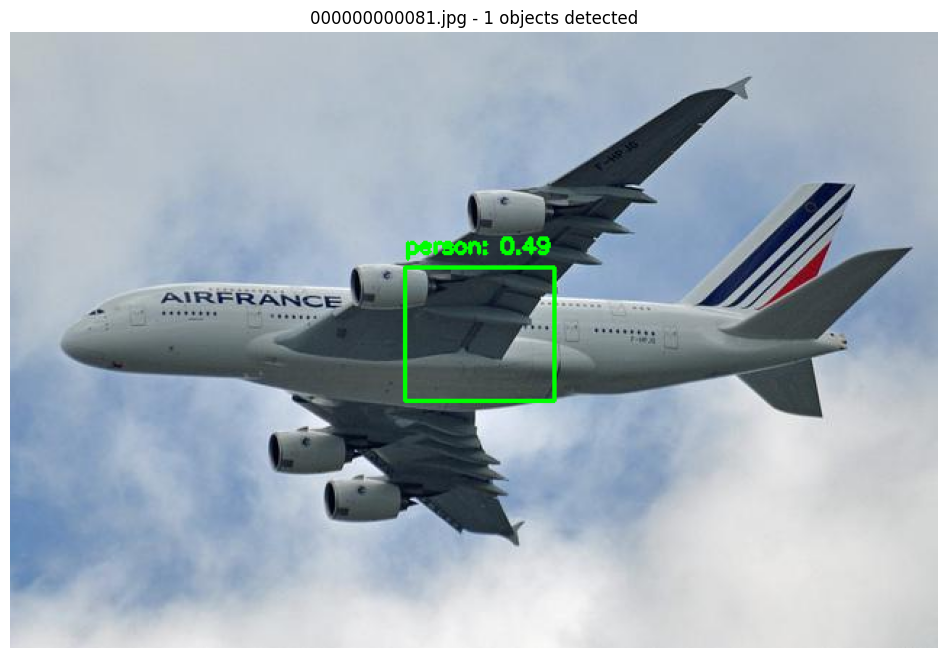


Image: 000000000081.jpg
Detected 1 objects:
  - person: 0.491


array([[[198, 195, 187],
        [198, 195, 187],
        [198, 195, 187],
        ...,
        [191, 182, 172],
        [191, 182, 172],
        [191, 182, 172]],

       [[198, 195, 187],
        [198, 195, 187],
        [198, 195, 187],
        ...,
        [192, 183, 173],
        [192, 183, 173],
        [192, 183, 173]],

       [[198, 195, 187],
        [198, 195, 187],
        [198, 195, 187],
        ...,
        [192, 183, 173],
        [192, 183, 173],
        [192, 183, 173]],

       ...,

       [[218, 210, 210],
        [220, 212, 212],
        [222, 214, 214],
        ...,
        [203, 202, 198],
        [202, 201, 197],
        [202, 201, 197]],

       [[220, 212, 212],
        [222, 214, 214],
        [224, 216, 216],
        ...,
        [204, 203, 199],
        [203, 202, 198],
        [203, 202, 198]],

       [[220, 215, 214],
        [220, 215, 214],
        [221, 216, 215],
        ...,
        [205, 204, 200],
        [204, 203, 199],
        [201, 200, 196]]], dtype=uint8)
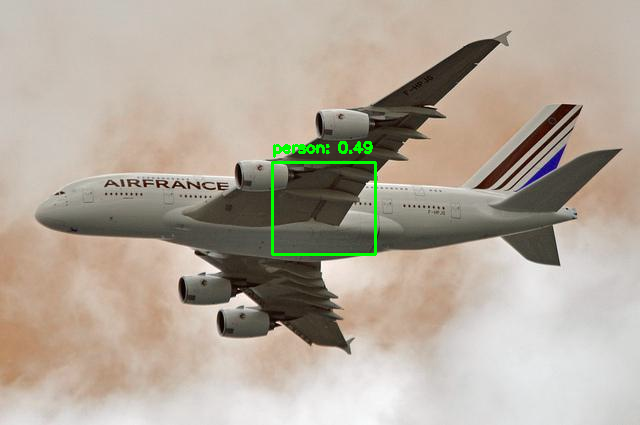

In [56]:
test_image(model, 15, conf_threshold=0.3)